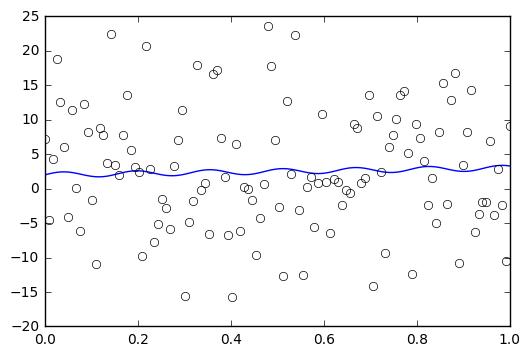

In [5]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import random

def f( x, p0, p1, p2):
    return p0*x + 0.4*np.sin(p1*x) + p2

def ff(x, p):
    return f(x, *p)

# These are the true parameters
p0 = 1.0
p1 = 40
p2 = 2.0

# These are initial guesses for fits:
pstart = [
    p0 + random.random(),
    p1 + 5.*random.random(), 
    p2 + random.random()
]

xvals = np.linspace(0., 1, 120)
yvals = f(xvals, p0, p1, p2)

# Generate data with a bit of randomness
xdata = np.array(xvals)
err_stdev = 10
yvals_err =  np.random.normal(0., err_stdev, len(xdata))
ydata = f(xdata, p0, p1, p2) + yvals_err

plt.plot(xvals, yvals)
plt.plot(xdata, ydata, 'o', mfc='None')
plt.show()

In [10]:
def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

pfit, perr = fit_leastsq(pstart, xdata, ydata, ff)


print 'true parameters= ', 'p0=1', 'p1=40', 'p2=',p2
print "fitted parameters=", pfit
print "error= ", perr

print "fractional difference", abs(pfit[0]-p0)/perr[0], abs(pfit[1]-p1)/perr[1], abs(pfit[2]-p2)/perr[2]

true parameters=  p0=1 p1=40 p2= 2.0
fitted parameters= [ -1.62422417  38.78698244   3.61810464]
error=  [ 2.77381878  4.94050559  1.59838754]
fractional difference 0.946069077562 0.245524984391 1.01233561756


In [8]:
def fit_curvefit(p0, datax, datay, function, yerr=err_stdev, **kwargs):

    pfit, pcov = \
         optimize.curve_fit(f,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

pfit, perr = fit_curvefit(pstart, xdata, ydata, ff)

print 'true parameters= ', 'p0=1.0', 'p1=40', 'p2=2.0'
print "fitted parameters=", pfit
print "error= ", perr
print "fractional difference", abs(pfit[0]-p0)/perr[0], abs(pfit[1]-p1)/perr[1], abs(pfit[2]-p2)/perr[2]

true parameters=  p0=1.0 p1=40 p2=2.0
fitted parameters= [ -1.62422417  38.78698244   3.61810464]
error=  [ 2.77381878  4.94050559  1.59838754]
fractional difference 0.946069077562 0.245524984391 1.01233561756


In [9]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

pfit, perr = fit_bootstrap(pstart, xdata, ydata, ff)

print 'true parameters= ', 'p0=1.0', 'p1=40', 'p2=2.0'
print "fitted parameters=", pfit
print "error= ", perr

print "fractional difference", abs(pfit[0]-p0)/perr[0], abs(pfit[1]-p1)/perr[1], abs(pfit[2]-p2)/perr[2]

true parameters=  p0=1.0 p1=40 p2=2.0
fitted parameters= [ -1.99208518  41.34906737   3.75325395]
error=  [ 2.83401584  4.92331379  1.61121034]
fractional difference 1.05577574495 0.274016126002 1.08815956762
